<a href="https://colab.research.google.com/github/rtnaka/ai_quest_assessment/blob/main/AI_Quest2021_%E3%82%A2%E3%82%BB%E3%82%B9%E3%83%A1%E3%83%B3%E3%83%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ライブラリのインストール

In [1]:
!pip install category_encoders
!pip install japanize-matplotlib
!pip install pandas_profiling
!pip install git+https://github.com/pfnet-research/xfeat.git

  Cloning https://github.com/pfnet-research/xfeat.git to /tmp/pip-req-build-h_lf40z4
  Running command git clone -q https://github.com/pfnet-research/xfeat.git /tmp/pip-req-build-h_lf40z4


## ライブラリのインポート

In [112]:
import re
import datetime
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
from scipy import stats
import sklearn
from tqdm.notebook import tqdm  as tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import japanize_matplotlib 

#EDA
from pandas_profiling import ProfileReport

#Feature Engneering
from sklearn.preprocessing import QuantileTransformer,StandardScaler
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder , CountEncoder
from xfeat import SelectCategorical, LabelEncoder, Pipeline, ConcatCombination, SelectNumerical, ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer
from sklearn.feature_extraction.text import TfidfVectorizer

#Modeling
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_squared_log_error, log_loss, roc_curve, confusion_matrix, plot_roc_curve
import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

## データの読み込み

In [3]:
# Google DriveをColabにマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#最大表示行数指定
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

In [5]:
# ファイルパス
basepath = '/content/drive/MyDrive/AI Quest2021 アセスメント/'

# 学習データ
df_train = pd.read_csv(basepath+'train.csv', index_col=0,parse_dates=["first_review", "host_since","last_review"])

# テストデータ
df_test = pd.read_csv(basepath+'test.csv', index_col=0,parse_dates=["first_review", "host_since","last_review"])

# 提出フォーマット
submission = pd.read_csv(basepath+'sample_submit.csv', index_col=0,header=None,names = ["","y"])

## 探索的データ解析

#### 行数と列数の確認　.shape

In [ ]:
# DataFrameの行数と列数の確認
print("学習データ",df_train.shape)
print("テストデータ",df_test.shape)
print("提出用サンプル",submission.shape)

#### テーブルデータの一部を確認

In [ ]:
# 先頭行の確認 df_train
df_train.head()

In [ ]:
# 先頭行の確認 df_test
df_test.head()

In [ ]:
# 先頭行の確認 submission
submission.head()

#### 特徴量（カラム）のデータ型の確認

In [ ]:
df_train.info()

In [ ]:
df_test.info()

#### 欠損・ユニーク数の確認

In [ ]:
#　データ型
dtypes = pd.DataFrame(df_train.dtypes)

# 欠損確認
total_nan = df_train.isnull().sum().sort_values(ascending=False)
percent_nan = (df_train.isnull().sum()/len(df_train)*100).sort_values(ascending=False)
df_nan = pd.concat([total_nan, percent_nan], axis=1, keys=['NaN合計', 'NaN 割合[%]'])

# ユニーク数確認
nunique = df_train.nunique().sort_values(ascending=False)
percent_unique = df_train.nunique().sort_values(ascending=False)/len(df_train)*100
df_nunique = pd.concat([nunique,percent_unique],axis=1,keys=["ユニーク数","ユニーク数 割合[%]"])

df_nanunique = pd.concat([df_nan,df_nunique,dtypes],axis=1)
df_uniquenan = pd.concat([df_nunique,df_nan,dtypes],axis=1)

In [ ]:
df_uniquenan.head(len(df_train))

In [ ]:
# 欠損確認
total_nan = df_test.isnull().sum().sort_values(ascending=False)
percent_nan = (df_test.isnull().sum()/len(df_test)*100).sort_values(ascending=False)
df_nan = pd.concat([total_nan, percent_nan], axis=1, keys=['NaN合計', 'NaN 割合[%]'])

# ユニーク数確認
nunique = df_test.nunique().sort_values(ascending=False)
percent_unique = df_test.nunique().sort_values(ascending=False)/len(df_train)*100
df_nunique = pd.concat([nunique,percent_unique],axis=1,keys=["ユニーク数","ユニーク数 割合[%]"])

df_nanunique = pd.concat([df_nan,df_nunique],axis=1)
df_uniquenan = pd.concat([df_nunique,df_nan],axis=1)

In [ ]:
df_nanunique.head(len(df_test))

#### 基本統計量　（数値特徴量）

In [ ]:
pd.options.display.float_format = '{:.7g}'.format

In [ ]:
df_train.describe()

In [ ]:
df_test.describe()

In [ ]:
# １7０0$以上の物件について中身を確認
neigh_hphotel = df_train[(df_train["y"] > 1500)&(df_train["accommodates"] <3) ]["neighbourhood"].values

In [ ]:
df_train[(df_train["y"] > 1300)&(df_train["accommodates"] <3) ]

In [ ]:
neigh_hphotel

In [ ]:
df_test[df_test["neighbourhood"].isin(neigh_hphotel)]

In [ ]:
# 10$以下の物件について中身を確認
df_train[df_train["y"] < 10 ]

In [6]:
delnums = [14807,39193,40313,40732,29385,34730]
for delnum in delnums :
  df_train.drop(delnum,inplace=True)

#### 数値特徴量のヒストグラムを確認

In [7]:
# dtypeが数値のカラム名

numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
numerical_feats

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'first_review',
       'host_since', 'last_review', 'latitude', 'longitude',
       'number_of_reviews', 'review_scores_rating', 'y'],
      dtype='object')

In [8]:
sns.displot(data=df_train,x="review_scores_rating")

#### 各特徴量を個別に確認

In [ ]:
# dtypeがobject（数値でないもの）のカラム名とユニーク数、欠損数の確認
# カテゴリ値のカラム確認
categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
categorical_feats

In [ ]:
# テキスト特徴量
col = "amenities"
df_train[col].unique()

In [ ]:
# カテゴリ　
col = "bed_type"
target = "y"

plt.figure(figsize=(20, 10))
sns.violinplot(data=df_train,x=col,y=target)
pd.DataFrame(df_train[col].value_counts().sort_values(ascending = False))

In [ ]:
col = "cancellation_policy"
plt.figure(figsize=(20, 10))
sns.violinplot(data=df_train,x=col,y=target)

pd.DataFrame(df_train[col].value_counts().sort_values(ascending = False))

In [ ]:
col = "city"

target = "y"
plt.figure(figsize=(20, 10))
sns.violinplot(data=df_train,x=col,y=target)

pd.DataFrame(df_test[col].value_counts().sort_values(ascending = False))

In [ ]:
col = "first_review"
pd.DataFrame(df_train[col].dt.year.value_counts())

In [ ]:
pd.DataFrame(df_test[col].dt.year.value_counts())

In [ ]:
df_train["y"].groupby(df_train[col].dt.year).mean()

In [ ]:
col = "host_has_profile_pic"
pd.DataFrame(df_train[col].value_counts().sort_values(ascending = False))

In [ ]:
pd.DataFrame(df_test[col].value_counts().sort_values(ascending = False))

In [ ]:
col = "host_identity_verified"
pd.DataFrame(df_train[col].value_counts().sort_values(ascending = False))

In [ ]:
pd.DataFrame(df_test[col].value_counts().sort_values(ascending = False))

In [ ]:
col = "host_response_rate"
pd.DataFrame(df_train[col].value_counts().sort_values(ascending = False))

In [ ]:
df_train[col].unique()

In [ ]:
col = "host_since"
pd.DataFrame(df_train[col].value_counts().sort_values(ascending = False))

In [ ]:
df_train["y"].groupby(df_train[col].dt.year).mean()

In [ ]:
col = "instant_bookable"
pd.DataFrame(df_train[col].value_counts().sort_values(ascending = False))

In [ ]:
col = "property_type"
pd.DataFrame(df_train[col].value_counts().sort_values(ascending = False))

## 特徴量エンジニアリング（Feature Engineering）

ture/false →　1/0 に変換
- cleaning_fee
- host_has_profile_pic	
- host_identity_verified
- instant_bookable

%を削除し数値変換
- host_response_rate

列削除
- latitude	longitude

欠損有無のみ列として残す
- thumbnail_url

桁数を減らして利用
- zipcode

2017/12/31を基準日とし、差分を取る
- first_review,last_review,host_since

#### Xとyに分割（X_train,y_train,X_testの生成）

In [72]:
# Xとyに分割 (X_train,y_train,X_test の生成)
target = "y"
y_train = df_train[target]
X_train = df_train.drop([target], axis=1)
X_test = df_test.copy()

#### 欠損数の追加

In [73]:
#NaNに関数特徴量を新たに作成
for col in X_train.columns:
    if X_train[col].isnull().any():
        X_train[col + '_isNaN'] = X_train[col].isnull().astype(int)
        X_test[col + '_isNaN'] = X_test[col].isnull().astype(int)   

X_train['null_count'] = X_train.isnull().sum(axis=1)
X_test['null_count'] = X_test.isnull().sum(axis=1)

#### 列削除

In [74]:
cols = ["thumbnail_url","latitude","longitude","name"]
X_train.drop(cols,axis = 1,inplace=True)
X_test.drop(cols,axis = 1,inplace=True)

#### ture/false →　1/0 に変換

In [75]:
cols = ["cleaning_fee","host_has_profile_pic","host_identity_verified","instant_bookable"]

for col in cols :
  X_train[col] = X_train[col].apply(lambda x: 1 if x == "t" else 0 )
  X_test[col] = X_test[col].apply(lambda x: 1 if x == "t" else 0)

#### %を削除し数値変換

In [76]:
col = "host_response_rate"
X_train[col].fillna("-1%",inplace=True)
X_test[col].fillna("-1%",inplace=True)
X_train[col] = X_train[col].str.strip('%').astype(float)
X_test[col] = X_test[col].str.strip('%').astype(float)

#### 桁数を減らして利用

In [77]:
col = "zipcode"
X_train[col].fillna("nan",inplace=True)
X_test[col].fillna("nan",inplace=True)
X_train[col] = X_train[col].apply(lambda x:x[:3])
X_test[col] = X_test[col].apply(lambda x:x[:3])

#### 2017/12/31を基準日とし、差分を取る

In [78]:
col = "last_review"
day = datetime.datetime(2017, 10, 31, 0, 0, 0)
X_train[col].fillna(day,inplace=True)
X_test[col].fillna(day,inplace=True)
X_train[col] =  X_train[col].apply(lambda x: day - x).dt.days
X_test[col] =  X_test[col].apply(lambda x: day - x).dt.days

In [79]:
cols = ["first_review","host_since"]

for col in cols:
  day = datetime.datetime(1,1,1, 0, 0, 0)
  X_train[col] =  X_train[col].apply(lambda x: str(x.year *100 + x.month))
  X_test[col] =  X_test[col].apply(lambda x: str(x.year *100 + x.month))

#### 欠損埋め

In [80]:
pd.DataFrame(X_train.isnull().sum().sort_values(ascending = False)).head(7)

,0
review_scores_rating,12552
neighbourhood,5160
bathrooms,147
beds,96
bedrooms,71
null_count,0
host_has_profile_pic,0


In [81]:
cols = ["beds","bedrooms","bathrooms"]
for col in cols:
  X_train[col].fillna(X_train[col].median(),inplace=True)
  X_test[col].fillna(X_test[col].median(),inplace=True)

In [82]:
col = "review_scores_rating"
X_train[col].fillna(-1,inplace=True)
X_test[col].fillna(-1,inplace=True)

col = "neighbourhood"
X_train[col].fillna("nan",inplace=True)
X_test[col].fillna("nan",inplace=True)

In [83]:
pd.DataFrame(X_train.isnull().sum().sort_values(ascending = False)).head()

,0
null_count,0
neighbourhood,0
instant_bookable,0
host_since,0
host_response_rate,0


In [84]:
X_train.head()

,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,zipcode,bathrooms_isNaN,bedrooms_isNaN,beds_isNaN,first_review_isNaN,host_has_profile_pic_isNaN,host_identity_verified_isNaN,host_response_rate_isNaN,host_since_isNaN,last_review_isNaN,neighbourhood_isNaN,review_scores_rating_isNaN,thumbnail_url_isNaN,zipcode_isNaN,null_count
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,6,"{TV,""Wireless Internet"",Kitchen,""Free parking ...",2.0,Real Bed,1.0,4.0,flexible,LA,1,My place is meant for family and a few friends...,201607,1,0,-1.0,201607,0,461,nan,1,Apartment,60.0,Private room,908,0,0,0,0,0,0,1,0,0,1,0,1,0,3
1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,1,This is a new listing for a lovely guest bedro...,201609,1,1,100.0,201512,0,214,Brookland,9,House,100.0,Private room,200,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,"{TV,Internet,""Wireless Internet"",Kitchen,""Indo...",2.0,Real Bed,1.0,1.0,strict,NYC,1,We're looking forward to your stay at our apt....,201606,1,0,100.0,201605,1,79,Bushwick,27,Apartment,83.0,Private room,nan,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,SF,1,BEST CITY VIEWS - - ROOF DECK W/ BBQ & WiFi - ...,201403,1,1,100.0,201206,1,58,Nob Hill,38,Apartment,95.0,Private room,941,0,0,0,0,0,0,0,0,0,0,0,1,0,1
4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,1,Charming Apartment on the upper west side of M...,201508,1,1,100.0,201503,0,51,Upper West Side,5,Apartment,100.0,Entire home/apt,100,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### 数値特徴量

In [85]:
# dtypeが数値のカラム名とユニーク数、欠損数の確認
# 数値のカラム確認

numerical_feats = X_train.dtypes[X_train.dtypes != "object"].index
numerical_feats

Index(['accommodates', 'bathrooms', 'bedrooms', 'beds', 'cleaning_fee',
       'host_has_profile_pic', 'host_identity_verified', 'host_response_rate',
       'instant_bookable', 'last_review', 'number_of_reviews',
       'review_scores_rating', 'bathrooms_isNaN', 'bedrooms_isNaN',
       'beds_isNaN', 'first_review_isNaN', 'host_has_profile_pic_isNaN',
       'host_identity_verified_isNaN', 'host_response_rate_isNaN',
       'host_since_isNaN', 'last_review_isNaN', 'neighbourhood_isNaN',
       'review_scores_rating_isNaN', 'thumbnail_url_isNaN', 'zipcode_isNaN',
       'null_count'],
      dtype='object')

In [86]:
# 数値特徴量２つの乗算を実施
encoder_num2 = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=['accommodates', 'bathrooms', 'bedrooms', 'beds'], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

combi_num2_train = encoder_num2.fit_transform(X_train)
combi_num2_test = encoder_num2.fit_transform(X_test)

X_train = pd.concat([X_train,combi_num2_train],axis=1)
X_test = pd.concat([X_test,combi_num2_test],axis=1)

In [87]:
# 数値特徴量２つの乗算を実施
encoder_num2 = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=['accommodates', 'bathrooms', 'bedrooms', 'beds'], 
            drop_origin=True, 
            operator="/", 
            r=2,
        ),
    ]
)

combi_num2_train = encoder_num2.fit_transform(X_train)
combi_num2_test = encoder_num2.fit_transform(X_test)

X_train = pd.concat([X_train,combi_num2_train],axis=1)
X_test = pd.concat([X_test,combi_num2_test],axis=1)

In [88]:
# 数値特徴量２つの乗算を実施
encoder_num2 = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=[ 'number_of_reviews','review_scores_rating'], 
            drop_origin=True, 
            operator="*", 
            r=2,
        ),
    ]
)

combi_num2_train = encoder_num2.fit_transform(X_train)
combi_num2_test = encoder_num2.fit_transform(X_test)

X_train = pd.concat([X_train,combi_num2_train],axis=1)
X_test = pd.concat([X_test,combi_num2_test],axis=1)

In [89]:
# 数値特徴量　host
encoder_num19 = Pipeline(
    [
        SelectNumerical(),
        ArithmeticCombinations(
            input_cols=['host_has_profile_pic', 'host_identity_verified', 'host_response_rate'], 
            drop_origin=True, 
            operator="+", 
            r=3,
        ),
    ]
)

combi_num19_train = encoder_num19.fit_transform(X_train)
combi_num19_test = encoder_num19.fit_transform(X_test)

X_train = pd.concat([X_train,combi_num19_train],axis=1)
X_test = pd.concat([X_test,combi_num19_test],axis=1)

### カテゴリ特徴量

In [90]:
# dtypeがobject（数値でないもの）
categorical_feats = X_train.dtypes[X_train.dtypes == "object"].index
categorical_feats = categorical_feats.drop(['amenities','description'])
categorical_feats

Index(['bed_type', 'cancellation_policy', 'city', 'first_review', 'host_since',
       'neighbourhood', 'property_type', 'room_type', 'zipcode'],
      dtype='object')

In [65]:
#カテゴリ変数の組み合わせを作成（組み合わせ数＝２）
encoder_str2 = Pipeline(
    [
      SelectCategorical(exclude_cols=['neighbourhood','first_review','host_since']),
      ConcatCombination(drop_origin=True, output_suffix="", r=2)
    ]
  )

combi_str2_train = encoder_str2.fit_transform(X_train)
combi_str2_test =  encoder_str2.fit_transform(X_test)
X_train = pd.concat([X_train,combi_str2_train],axis=1)
X_test = pd.concat([X_test,combi_str2_test],axis=1)

TypeError: ignored

In [66]:
# dtypeがobject（数値でないもの）
categorical_feats = X_train.dtypes[X_train.dtypes == "object"].index
categorical_feats = categorical_feats.drop(['amenities','description'])
categorical_feats

Index(['bed_type', 'cancellation_policy', 'city', 'first_review', 'host_since',
       'neighbourhood', 'property_type', 'room_type', 'zipcode'],
      dtype='object')

In [31]:
df_train.groupby("city")["y"].mean()

city
Boston     165.629287
Chicago    133.935162
DC         216.976750
LA         154.555324
NYC        143.043662
SF         227.678556
Name: y, dtype: float64

In [91]:
citys = {
  "Boston":165,
  "Chicago":133,
  "DC":216,
  "LA":154,
  "NYC":143,
  "SF":227
}

col = "city"
X_train[col] = X_train[col].map(citys)
X_test[col] = X_test[col].map(citys)

In [33]:
df_train.groupby("cancellation_policy")["y"].mean()

cancellation_policy
flexible            149.494432
moderate            141.202828
strict              177.640607
super_strict_30     260.038462
super_strict_60    1062.461538
Name: y, dtype: float64

In [92]:
citys = {
  "flexible":149,
  "moderate":141,
  "strict":177,
  "super_strict_30":260,
  "super_strict_60":1062,
}

col = "cancellation_policy"
X_train[col] = X_train[col].map(citys)
X_test[col] = X_test[col].map(citys)

In [35]:
df_train.groupby("bed_type")["y"].mean()

bed_type
Airbed           105.732044
Couch            112.197115
Futon             94.186292
Pull-out Sofa     99.801325
Real Bed         161.794221
Name: y, dtype: float64

In [93]:
citys = {
  "Airbed":105,
  "Couch":112,
  "Futon":94,
  "Pull-out Sofa":99,
  "Real Bed":161,
}

col = "bed_type"
X_train[col] = X_train[col].map(citys)
X_test[col] = X_test[col].map(citys)

In [37]:
df_train.groupby("room_type")["y"].mean()

room_type
Entire home/apt    218.534103
Private room        88.181573
Shared room         64.367901
Name: y, dtype: float64

In [94]:
citys = {
  "Entire home/apt":218,
  "Private room":88,
  "Shared room":64
}

col = "room_type"
X_train[col] = X_train[col].map(citys)
X_test[col] = X_test[col].map(citys)

In [71]:
# dtypeがobject（数値でないもの）
categorical_feats = X_train.dtypes[X_train.dtypes == "object"].index
categorical_feats = categorical_feats.drop(['amenities','description'])
categorical_feats

Index(['first_review', 'host_since', 'neighbourhood', 'property_type',
       'zipcode'],
      dtype='object')

In [95]:
# Target Encoding
y_train_bin = pd.cut(y_train , 10, labels=False).astype(int)
target = 'y'
X_temp = pd.concat([X_train, y_train], axis=1)

for col in categorical_feats:

    # X_testはX_trainでエンコーディングする
    summary = X_temp.groupby([col])[target].mean()
    X_test[col] = X_test[col].map(summary) 


    # X_trainのカテゴリ変数をoofでエンコーディングする
    skf = StratifiedKFold(n_splits=5, random_state=71, shuffle=True)
    enc_train = pd.Series(np.zeros(len(X_train)), index=X_train.index)

    for i, (train_ix, val_ix) in enumerate((skf.split(X_train, y_train_bin))):
        X_train_, _ = X_temp.iloc[train_ix], y_train.iloc[train_ix]
        X_val, _ = X_temp.iloc[val_ix], y_train.iloc[val_ix]

        summary = X_train_.groupby([col])[target].mean()
        enc_train.iloc[val_ix] = X_val[col].map(summary)
        
    X_train[col]  = enc_train

In [96]:
enctrain = X_train.copy()
enctest = X_test.copy()

### テキスト特徴量

In [97]:
#大文字→小文字変換
cols = ["amenities","description"]
for col in cols:
  enctrain[col] = enctrain[col].str.lower()
  enctest[col] = enctest[col].str.lower()

In [98]:
cols = ["amenities","description"]

enctrain_copy = enctrain.copy()
enctest_copy = enctest.copy()

enctrain.drop(cols,axis=1,inplace=True)
enctest.drop(cols,axis=1,inplace=True)


for col in cols:
  tfidf_train = TfidfVectorizer(max_features=50)
  enctrain_tfidf = tfidf_train.fit_transform(enctrain_copy[col].values.astype('U'))

  tfidf_test = TfidfVectorizer(max_features=50 , vocabulary=tfidf_train.vocabulary)
  enctest_tfidf = tfidf_test.fit_transform(enctest_copy[col].values.astype('U'))

  enctrain = sp.sparse.hstack([enctrain.values, enctrain_tfidf]).todense()
  enctrain = pd.DataFrame(enctrain)
  enctest = sp.sparse.hstack([enctest.values, enctest_tfidf]).todense()
  enctest = pd.DataFrame(enctest)

## モデリング

In [100]:
X_train = enctrain.copy()
X_test = enctest.copy()

In [101]:
X_train.shape,X_test.shape

((55577, 149), (18528, 149))

In [102]:
y_train_bin = pd.cut(y_train ,10, labels=False).astype(int)

In [103]:
def train_and_predict(x_train,y_train,x_test,seeds) :

  clf = LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.7,
                                importance_type='split', learning_rate=0.05, max_depth=-1,
                                min_child_samples=10, min_child_weight=0.001, min_split_gain=0.0,
                                n_estimators=9999, n_jobs=-1, num_leaves=15, objective='regression',
                                random_state=71, reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


  scores = []
  preds = []
  
  for seed in tqdm(seeds):
    skf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)
    y_test_pred = np.zeros(len(x_test))

    for i, (train_ix, test_ix) in enumerate(skf.split(x_train, y_train_bin)):
      x_train_, y_train_ = x_train.values[train_ix], y_train.values[train_ix]
      x_val, y_val = x_train.values[test_ix], y_train.values[test_ix]
      
      clf.fit(x_train_, y_train_, early_stopping_rounds=10, eval_metric='rmse', eval_set=[(x_val, y_val)])
      y_val_pred = clf.predict(x_val)
      print('CV Split Score is %f' % (np.sqrt(mean_squared_error(y_val, y_val_pred))))
      scores.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))

      y_test_pred += clf.predict(x_test)

    #CV毎のテストデータ予測結果の平均を取り、predに代入
    y_test_pred /= 5
    preds.append(y_test_pred)

    #seed毎に計算されるテストデータ予測予測結果の平均を取る
    cv_scores_ave = np.mean(scores,axis=0)

    #全CVの交差検定スコアの平均を取る
    pred = np.mean(preds, axis=0)

    #変数重要度
    feature_importance = pd.DataFrame(
                                          clf.booster_.feature_importance(importance_type='gain'), 
                                          index = x_train.columns, columns=['importance']).sort_values(['importance'], 
                                          ascending=False
                                        )

  return pred , cv_scores_ave , feature_importance

In [104]:
seeds = [31,71,91]
pred , cv_scores_ave , feature_importance = train_and_predict(X_train,y_train,X_test,seeds)

[1]	valid_0's rmse: 163.519	valid_0's l2: 26738.4
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 159.776	valid_0's l2: 25528.2
[3]	valid_0's rmse: 156.321	valid_0's l2: 24436.4
[4]	valid_0's rmse: 152.984	valid_0's l2: 23404
[5]	valid_0's rmse: 149.951	valid_0's l2: 22485.3
[6]	valid_0's rmse: 147.174	valid_0's l2: 21660.2
[7]	valid_0's rmse: 144.469	valid_0's l2: 20871.3
[8]	valid_0's rmse: 142.174	valid_0's l2: 20213.4
[9]	valid_0's rmse: 139.891	valid_0's l2: 19569.6
[10]	valid_0's rmse: 137.779	valid_0's l2: 18983
[11]	valid_0's rmse: 135.752	valid_0's l2: 18428.7
[12]	valid_0's rmse: 133.916	valid_0's l2: 17933.5
[13]	valid_0's rmse: 132.142	valid_0's l2: 17461.4
[14]	valid_0's rmse: 130.533	valid_0's l2: 17038.9
[15]	valid_0's rmse: 129.056	valid_0's l2: 16655.5
[16]	valid_0's rmse: 127.581	valid_0's l2: 16276.8
[17]	valid_0's rmse: 126.182	valid_0's l2: 15921.8
[18]	valid_0's rmse: 124.964	valid_0's l2: 15616.1
[19]	valid_0's rmse: 123.731	vali

In [105]:
target = "y"
submission[target] = pred

In [106]:
submission[submission[target] < 10 ]

,y
,


In [107]:
submission[target] = submission[target].astype(int)

In [108]:
submission.describe()

,y
count,18528.000000
mean,158.968804
std,125.545505
min,16.000000
25%,83.000000
50%,123.000000
75%,183.000000
max,1432.000000


In [109]:
len(feature_importance)

149

In [110]:
use_col  = feature_importance.index[:100]
seeds = [31,71,91]
pred , cv_scores_ave , feature_importance = train_and_predict(X_train[use_col],y_train,X_test[use_col],seeds)

[1]	valid_0's rmse: 163.39	valid_0's l2: 26696.4
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 159.676	valid_0's l2: 25496.4
[3]	valid_0's rmse: 156.272	valid_0's l2: 24421
[4]	valid_0's rmse: 153.134	valid_0's l2: 23450.1
[5]	valid_0's rmse: 150.108	valid_0's l2: 22532.3
[6]	valid_0's rmse: 147.283	valid_0's l2: 21692.2
[7]	valid_0's rmse: 144.544	valid_0's l2: 20893
[8]	valid_0's rmse: 142.012	valid_0's l2: 20167.3
[9]	valid_0's rmse: 139.826	valid_0's l2: 19551.2
[10]	valid_0's rmse: 137.721	valid_0's l2: 18967.1
[11]	valid_0's rmse: 135.645	valid_0's l2: 18399.5
[12]	valid_0's rmse: 133.682	valid_0's l2: 17870.8
[13]	valid_0's rmse: 131.944	valid_0's l2: 17409.2
[14]	valid_0's rmse: 130.358	valid_0's l2: 16993.2
[15]	valid_0's rmse: 128.818	valid_0's l2: 16594.2
[16]	valid_0's rmse: 127.328	valid_0's l2: 16212.3
[17]	valid_0's rmse: 126.009	valid_0's l2: 15878.2
[18]	valid_0's rmse: 124.785	valid_0's l2: 15571.2
[19]	valid_0's rmse: 123.631	valid

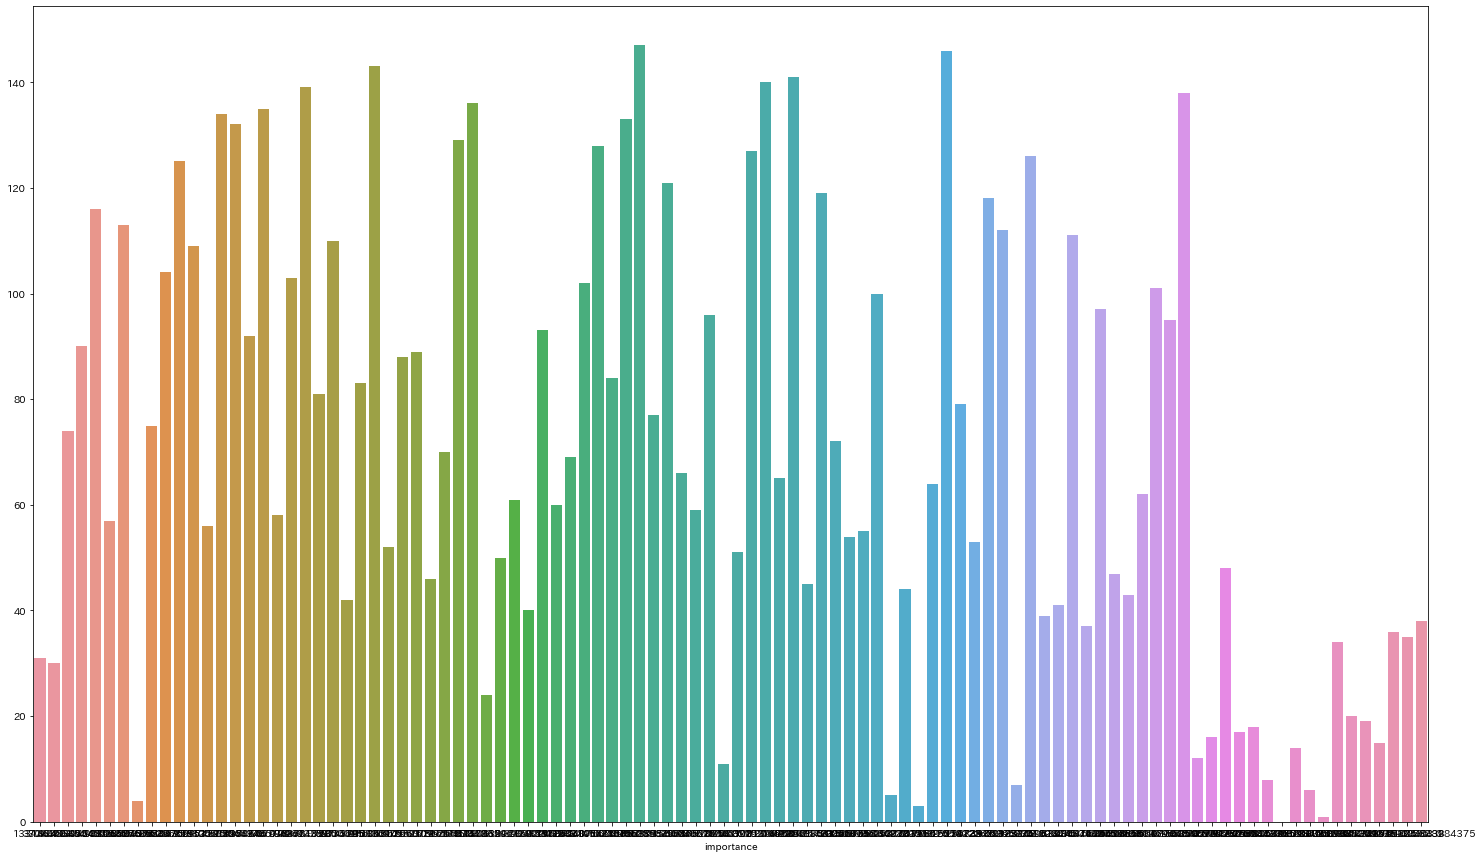

In [113]:
figure = plt.figure(figsize=(25, 15))
sns.barplot(x="importance", y=feature_importance.index, data=feature_importance)

In [114]:
target = "y"
submission[target] = pred
submission.describe()

,y
count,18528.000000
mean,159.025782
std,125.248265
min,14.976654
25%,83.326205
50%,123.535633
75%,182.754203
max,1445.909317


In [115]:
submission[target] = submission[target].astype(int)

In [116]:
submission.describe()

,y
count,18528.000000
mean,158.526770
std,125.246157
min,14.000000
25%,83.000000
50%,123.000000
75%,182.000000
max,1445.000000


In [117]:
submission.to_csv(basepath+'submit_04.csv',header=None)

In [ ]:
submission
